Keras CNN으로 폐렴 X-RAY 분류하기

패키지 수입

In [ ]:
# 1번 블럭

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from time import time
from sklearn.metrics import confusion_matrix, f1_score

from keras.models import Model
from keras.layers import Conv2D, SeparableConv2D
from keras.layers import Input, Flatten
from keras.layers import BatchNormalization, MaxPool2D
from keras.layers import Dense, Dropout
from keras.preprocessing.image import load_img

In [ ]:
# 2번 블럭

MY_EPOCH = 200
MY_BATCH = 100
MY_RES = 180
MY_SHAPE = (MY_RES, MY_RES , 3)

# 모드 설정
DATA_MODE = 0
TRAIN_MODE = 0
MY_PATH = '/content/drive/MyDrive/dataset/chest'

2. 데이터 처리

In [ ]:
# 3번 블럭
# 변수 정의
# T_tot : train_tot, 학습용 이미지 갯수
# V_tot : validation total, 평가용 이미지 갯수
# N_tot : normal total, 정상 이미지 갯수
# P_tot : pnenmonia total, 폐렴 이미지 갯수
# N_path : normal image path, 정상 이미지 경로
# P_path : pneumonia image path, 폐렴 이미지 경로

# 변수 초기화
T_tot = V_tot = N_tot = P_tot = 0
N_path = P_path = []

# 학습용 입력 데이터
X_train = np.zeros((0))

# 학습용 출력 데이터
Y_train = np.zeros((0))

# 평가용 입력 데이터
X_test = np.zeros((0))

# 평가용 출력 데이터
Y_test = np.zeros((0))

In [ ]:
# 4번 블럭
# 학습용 이미지 경로 처리

def train_path():
  global T_tot, N_tot, P_tot, N_path, P_path

  # 정상 이미지 처리
  dir = os.path.join(MY_PATH,'train/NORMAL')
  print(dir)

  # 이미지 경로 모음
  N_path = []
  for f in sorted(os.listdir(dir)):
    N_path.append(os.path.join(dir, f))
  print('학습용 정상 이미지 갯수:', len(N_path))
  N_tot = len(N_path)

  # 폐렴 이미지 처리
  dir = os.path.join(MY_PATH,'train/PNEUMONIA')
  print(dir)

  # 이미지 경로 모음
  P_path = []
  for f in sorted(os.listdir(dir)):
    P_path.append(os.path.join(dir, f))
  print('학습용 폐렴 이미지 갯수: ',len(P_path))
  P_tot = len(P_path)

  # 총 학습용 이미지 갯수
  T_tot = N_tot + P_tot
  print('총 학습용 이미지 갯수: ',T_tot)

train_path()

/content/drive/MyDrive/dataset/chest/train/NORMAL
학습용 정상 이미지 갯수: 500
/content/drive/MyDrive/dataset/chest/train/PNEUMONIA
학습용 폐렴 이미지 갯수:  500
총 학습용 이미지 갯수:  1000


In [ ]:
# 5번 블락
# 학습용 이미지 화소 통일

def train_resize():
  global T_tot, N_tot,P_tot,N_path,P_path
  global X_train, Y_train
  
  print('학습용 정상 이미지 처리 시작')
  begin = time()

  # 학습용 입력 데이터 4차원
  X_train = np.zeros((T_tot, MY_RES, MY_RES, 3))
  
  # 학습용 출력데이터는 1차원
  Y_train = np.zeros((T_tot, ))
  
  # 이미지 파일 하나씩 처리
  # 이미지 라벨: 0은 정상값, 1은 폐렴값
  for i, path in enumerate(N_path):
    # tmp = load_img(path)
    # print('원본 픽셀 수:',np.array(tmp).shape)
    # plt.imshow(tmp)
    # plt.show()

    img = load_img(path, target_size=(MY_RES, MY_RES))
    # print('처리 후 픽셀 수:',np.array(img).shape)
    # plt.imshow(img)
    # plt.show()
    # break

    X_train[i] = img
    Y_train[i] = 0
    
  end = time()
  print('학습용 정상 이미지 처리 시간:{:.2f}'.format(end-begin))

  print('학습용 폐렴 이미지 처리 시작')
  begin = time()
  for i,path in enumerate(P_path):
    img = load_img(path, target_size=(MY_RES,MY_RES))
    X_train[i+ N_tot] = img
    Y_train[i+ N_tot] = 1
  end = time()
  print('학습용 정상 이미지 처리 시간:{:.2f}'.format(end-begin))

  # 데이터 스케일링
  print('전',X_train[0].flatten())
  X_train =X_train / 255.0
  print('후',X_train[0].flatten())

In [ ]:
# 6번 블럭 (4번 블럭과 흡사)
# 평가용 데이터 경로 처리

def test_path():
  global V_tot,N_tot,P_tot,N_path,P_path

  # 정상 이미지 처리
  dir = os.path.join(MY_PATH,'test/NORMAL')
  print(dir)

  # 정상 이미지 파일 경로 수집
  N_path = []
  for f in sorted(os.listdir(dir)):
    N_path.append(os.path.join(dir, f))
  print('평가용 정상 이미지 수', len(N_path))
  N_tot = len(N_path)

  # 폐렴 이미지 처리
  dir = os.path.join(MY_PATH,'test/PNEUMONIA')
  print(dir)

  # 폐렴 이미지 파일 경로 수집
  P_path = []
  for f in sorted(os.listdir(dir)):
    P_path.append(os.path.join(dir, f))
  print('평가용 정상 이미지 수', len(P_path))
  P_tot = len(P_path)

  # 총 평가용 이미지 갯수
  V_tot = N_tot + P_tot
  print('총 평가용 이미지 갯수:', V_tot)

In [ ]:
# 7번 블락 (5번 블락과 흡사)
# 평가용 이미지 화상도 통일 및 라벨 처리

def test_resize():
  global V_tot,N_tot,P_tot,N_path,P_path
  global X_test, Y_test

  print('평가용 정상 이미지 처리 시작')
  begin = time()

  X_test = np.zeros((V_tot, MY_RES, MY_RES, 3))
  Y_test = np.zeros((V_tot, ))

  for i, path in enumerate(N_path):
    img = load_img(path, target_size=(MY_RES, MY_RES))
    X_test[i] = img
    Y_test[i] = 0

  end = time()
  print('평가용 정상 이미지 처리 시간:{:.2f}'.format(end-begin))

  print('평가용 폐렴 이미지 처리 시작')
  begin = time()
  for i, path in enumerate(P_path):
    img = load_img(path, target_size=(MY_RES, MY_RES))
    X_test[i + N_tot] = img
    Y_test[i + N_tot] = 1

  end = time()
  print('평가용 폐렴 이미지 처리 시간:{:.2f}'.format(end-begin))

  # 데이터 스케일링
  X_test = X_test / 255.0

In [ ]:
# 8번 블럭
# 4분할 numpy 데이터 저장

def save_numpy():
  with open('chest-array.npy','wb') as f:
    np.save(f, X_train)
    np.save(f, Y_train)
    np.save(f, X_test)
    np.save(f, Y_test)

  print('4분할 데이터 저장 완료')

In [ ]:
# 9번 블럭
# 4분할 데이터 읽기

def load_numpy():
  global X_train,Y_train,X_test,Y_test

  with open('/content/drive/MyDrive/dataset/chest-array.npy','rb') as f:
    X_train = np.load(f)
    Y_train = np.load(f)
    X_test = np.load(f)
    Y_test = np.load(f)
  
  print('4분할 데이터 읽기 완료')

In [ ]:
# 10번 블럭
# 데이터 처리 컨트롤 타워

if DATA_MODE:
  train_path()
  train_resize()
  test_path()
  test_resize()
  save_numpy()
else:
  load_numpy()

4분할 데이터 읽기 완료


In [ ]:
# 11번 블럭
# 데이터 모양 확인

print('학습용 입력 데이터: ',X_train.shape)
print('학습용 출력 데이터: ',Y_train.shape)
print('평가용 입력 데이터: ',X_test.shape)
print('평가용 출력 데이터: ',Y_test.shape)

학습용 입력 데이터:  (1000, 180, 180, 3)
학습용 출력 데이터:  (1000,)
평가용 입력 데이터:  (204, 180, 180, 3)
평가용 출력 데이터:  (204,)


[7, 608, 33, 931, 76, 86, 470, 579, 563, 529, 936, 666, 342, 109, 144, 184]


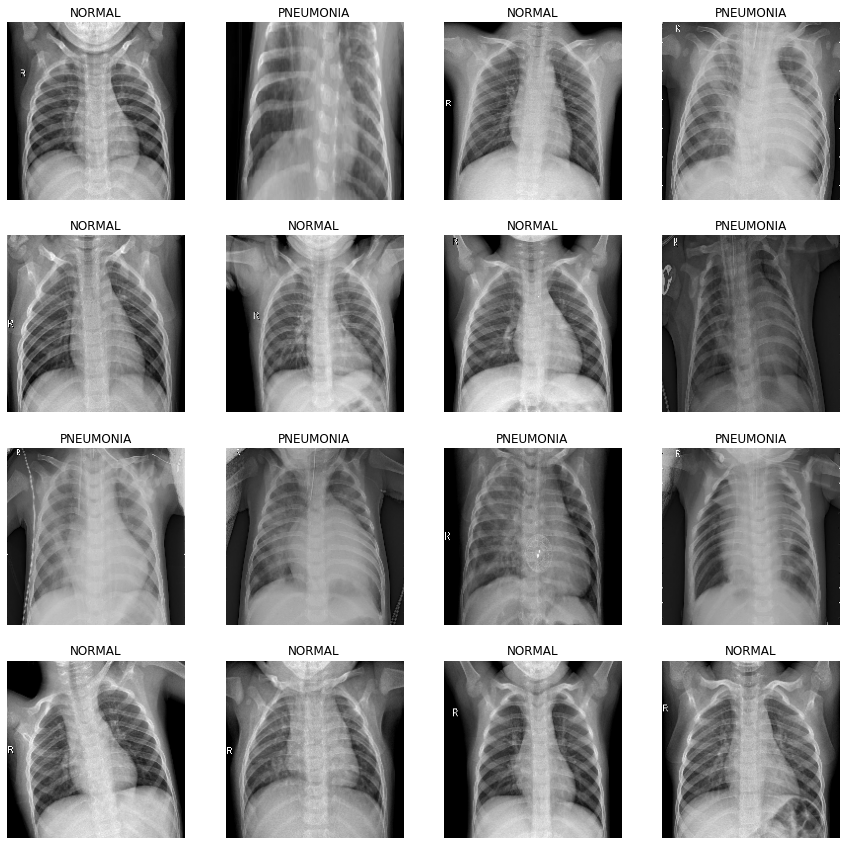

In [ ]:
# 12번 블럭
# 샘플 이미지 16을 4x4 프레임으로  출력 후 파일로 저장
# X_train에서 (학습용 입력 이미지에서 16개 무작위로 추출)

total =  len(X_train)
pick = random.sample(range(0,total),16)
print(pick)

fig, spot = plt.subplots(4, 4, figsize=(15,15))
cnt = 0

for i in range(4):
  for j in range(4):
    spot[i,j].imshow(X_train[pick[cnt]])

    #라벨 정보 추가
    label = Y_train[pick[cnt]]
    if label:
      spot[i,j].title.set_text('PNEUMONIA')
    else:
      spot[i,j].title.set_text('NORMAL')
    spot[i,j].axis('off')
    cnt += 1

plt.savefig('sample.png')

3. 인공 신경망 구현

In [ ]:
# 13번 블럭
# 합성곱 블락

def conv_block(filters, inputs):
  x = SeparableConv2D(filters=filters,
                      kernel_size = 3,
                      activation = 'relu',
                      padding = 'same')(inputs)
  x = SeparableConv2D(filters=filters,
                      kernel_size = 3,
                      activation = 'relu',
                      padding = 'same')(x)

  x = BatchNormalization()(x)

  output = MaxPool2D(pool_size=2)(x)

  return output

In [ ]:
# 14번 블럭
# dense 블럭 구현

def dense_block(units, drop, inputs):
  x = Dense(units=units,
            activation = 'relu')(inputs)
  
  x = BatchNormalization()(x)
  output = Dropout(drop)(x)

  return output

In [ ]:
# 15번 블럭
# 전체 CNN 구성

# 1번 층: 입력층
my_input = Input(shape=(MY_SHAPE))

# 2번 층
x = Conv2D(filters=16,
           kernel_size = 3,
           activation='relu',
           padding='same')(my_input)

x = Conv2D(filters=16,
           kernel_size = 3,
           activation='relu',
           padding='same')(x)

x = MaxPool2D(pool_size=2)(x)

# 3번 블럭
x = conv_block(32,x)

# 4번 블럭
x = conv_block(64,x)

# 5번 블럭
x = conv_block(128,x)
x = Dropout(0.2)(x)

# 6번 블럭
x = conv_block(256,x)
x = Dropout(0.2)(x)

# 7번 블럭
x= Flatten()(x)

# 8번 블럭
x = dense_block(512, 0.7, x)
x = dense_block(128, 0.5, x)
x = dense_block(64, 0.3, x)

# 9번 블럭
my_output = Dense(units=1,
            activation = 'sigmoid')(x)

# 모델 만들고 요약
model = Model(inputs=my_input,
              outputs = my_output)

print('CNN 요약')
model.summary()

CNN 요약
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 90, 90, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 90, 90, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 90, 32)       

4. 인공 신경망 학습

In [ ]:
# 16번 블럭
# CNN 학습 환경 설정

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics=['acc'])
# 학습 모드 구현
if TRAIN_MODE:

  # 학습 진행
  begin = time()
  print('학습 시작')

  model.fit(x = X_train,
            y= Y_train,
            epochs=MY_EPOCH,
            batch_size=MY_BATCH,
            verbose=1)

  end = time()
  print('총 학습 시간: {: .2f}'.format(end-begin))
  model.save_weights('pneumonia.h5')
else:
  model.load_weights('pneumonia.h5')

In [ ]:
# 17번 블럭
# CNN 평가

score = model.evaluate(x=X_test,
                       y=Y_test,
                       verbose=1)

print('최종 손실값:{: .2f}'.format(score[0]))
print('최종 정확도:{: .2f}'.format(score[1]))

7/7 [==============================] - 4s 45ms/step - loss: 1.1433 - acc: 0.8534
최종 손실값: 0.94
최종 정확도: 0.88


[123] 번 사진
정답: [1.]
예측 [[1.4388829e-05]]


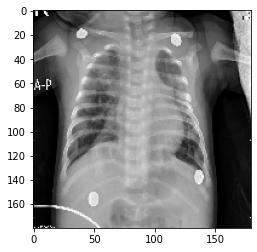

In [ ]:
# 18번 블럭

total = len(X_test)
pick = random.sample(range(0,total), 1)
print(pick,'번 사진')

plt.imshow(X_test[pick].reshape(MY_RES,MY_RES,3))

img = X_test[pick].reshape(1,MY_RES,MY_RES,3)
pred = model.predict(img)

print('정답:',Y_test[pick])
print('예측',pred)

In [ ]:
# 19번 블럭
# 혼동 행렬 출력

print('혼동 행렬')
pred = model.predict(X_test)
print(pred.flatten())

pred = (pred > 0.5)
print(pred.flatten())

print(confusion_matrix(Y_test, pred))

혼동 행렬
[6.03275730e-05 7.16048013e-03 1.19664437e-05 8.12100545e-02
 2.23971510e-05 6.92464600e-05 1.95120556e-05 7.62813579e-05
 7.01384561e-04 4.02734186e-05 2.82666188e-05 9.79418516e-01
 7.58905117e-06 2.85701244e-05 9.99668479e-01 2.58294371e-04
 9.99979019e-01 4.52629538e-05 2.03769719e-06 1.06225943e-05
 1.71552783e-05 1.12467065e-01 5.29971789e-04 1.65415477e-05
 1.44886999e-05 1.02273525e-05 1.20245792e-01 8.52799440e-06
 1.56131428e-05 1.73566350e-05 1.30891685e-05 6.22482225e-03
 4.53029825e-05 7.49381616e-06 3.18736076e-01 2.16679728e-05
 3.92291668e-07 3.46675297e-05 6.50179254e-06 7.62749141e-06
 9.98836577e-01 8.40585199e-06 5.62333980e-06 7.39298275e-06
 9.97723281e-01 9.99927878e-01 9.99958634e-01 9.99402881e-01
 6.06885910e-01 9.99590576e-01 1.64367248e-05 5.40591100e-05
 9.99964356e-01 1.11352665e-05 9.99985337e-01 1.04774032e-02
 5.26200456e-05 3.95523980e-02 8.81872711e-06 9.99970913e-01
 4.89048369e-04 2.49126469e-06 1.77063030e-05 1.50396581e-05
 4.21225850e-05 9.